In [48]:
import chess
import math
from numpy.random import randint

In [55]:
class RandomBot:
    def __init__(self,board):
        self.board=board
        
    def select_move(self):
        moves=list(self.board.legal_moves)
        return moves[randint(len(moves))]


class MCTSNode:
    def __init__(self, game_state, parent=None, move=None):
        self.game_state = game_state
        self.parent = parent
        self.move = move
        self.white=0
        self.black=1
        self.win_counts = {
            self.white: 0,
            self.black: 0,
        }
        self.num_rollouts = 0
        self.children = []
        self.unvisited_moves = list(game_state.legal_moves)
# end::mcts-node[]

# tag::mcts-add-child[]
    def add_random_child(self):
        index = randint(len(self.unvisited_moves))
        new_move = self.unvisited_moves.pop(index)#Pop elimina el elemento del arreglo
        new_game_state = self.game_state.copy()
        new_game_state.push(new_move)
        new_node = MCTSNode(new_game_state, self, new_move)
        self.children.append(new_node)
        return new_node
# end::mcts-add-child[]

# tag::mcts-record-win[]
    def record_win(self, winner):
        self.win_counts[self.white] += winner[0]
        self.win_counts[self.black] += winner[0]
        self.num_rollouts += 1
# end::mcts-record-win[]

# tag::mcts-readers[]
    def can_add_child(self):
        return len(self.unvisited_moves) > 0

    def is_terminal(self):
        return self.game_state.is_game_over()

    def winning_frac(self, player):
        if player:
            return float(self.win_counts[self.white]) / float(self.num_rollouts)
        else:
            return float(self.win_counts[self.black]) / float(self.num_rollouts)
# end::mcts-readers[]

class MCTSBot:
    def __init__(self, num_rounds, temperature):
        self.num_rounds = num_rounds
        self.temperature = temperature
        
# tag::mcts-signature[]
    def select_move(self, game_state):
        root = MCTSNode(game_state)
# end::mcts-signature[]

# tag::mcts-rounds[]
        print("\n")
        for i in range(self.num_rounds):
            print(i,end=" ")
            node = root
            while (not node.can_add_child()) and (not node.is_terminal()):
                node = self.select_child(node)

            # Add a new child node into the tree.
            if node.can_add_child():
                node = node.add_random_child()

            # Simulate a random game from this node.
            winner = self.simulate_random_game(node.game_state.copy())

            # Propagate scores back up the tree.
            while node is not None:
                node.record_win(winner)
                node = node.parent
# end::mcts-rounds[]

        scored_moves = [
            (child.winning_frac(game_state.turn), child.move, child.num_rollouts)
            for child in root.children
        ]
        scored_moves.sort(key=lambda x: x[0], reverse=True)
        for s, m, n in scored_moves[:10]:
            print('%s - %.3f (%d)' % (m, s, n))

# tag::mcts-selection[]
        # Having performed as many MCTS rounds as we have time for, we
        # now pick a move.
        best_move = None
        best_pct = -1.0
        for child in root.children:
            child_pct = child.winning_frac(game_state.turn)
            if child_pct > best_pct:
                best_pct = child_pct
                best_move = child.move
        print('Select move %s with win pct %.3f' % (best_move, best_pct))
        #show_tree(root,max_depth=10)
        return best_move
# end::mcts-selection[]

# tag::mcts-uct[]
    def select_child(self, node):
        """Select a child according to the upper confidence bound for
        trees (UCT) metric.
        """

        #Calcula N(v)
        total_rollouts = sum(child.num_rollouts for child in node.children)
        log_rollouts = math.log(total_rollouts)

        best_score = -1
        best_child = None
        # Loop over each child.
        #Calcula UTC(j)
        for child in node.children:
            # Calculate the UCT score.
            win_percentage = child.winning_frac(node.game_state.turn)
            exploration_factor = math.sqrt(log_rollouts / child.num_rollouts)
            uct_score = win_percentage + self.temperature * exploration_factor
            # Check if this is the largest we've seen so far.
            if uct_score > best_score:
                best_score = uct_score
                best_child = child
        return best_child
    
    def evaluar(self,b):
        mapeo={
            'r':5.63,
            'n':3.05,
            'b':3.33,
            'q':9.5,
            'p':1,
        }
        b=str(b).replace('\n','').replace(' ','').replace('.','').replace('k','').replace('K','')
        white=0.1
        black=0.1
        for i in b:
            if i.islower():
                black+=mapeo[i]
            else:
                white+=mapeo[i.lower()]
        return [round(white/(white+black),5),round(black/(white+black),5)]

    def simulate_random_game(self,board):
        bot = RandomBot(board)
        while not board.is_game_over():
            board.push(bot.select_move())
        s=board.result()
        if '1/2' in s:
            return self.evaluar(board)
        else:
            return [int(s[0]),int(s[2])]
        #list(map(int,s.split('-')))
        
        
    
        

In [56]:


def show_tree(node, indent='', max_depth=10):
    if max_depth < 0:
        return
    if node is None:
        return
    if node.parent is None:
        print('%sroot' % indent)
    else:
        player = node.parent.game_state.turn
        if player:
            player=0
        else:
            player=1
        move = node.move
        print('%s %d %.3f' % (
            indent,
            node.num_rollouts,
            node.winning_frac(player),
        ))
    for child in sorted(node.children, key=lambda n: n.num_rollouts, reverse=True):
        show_tree(child, indent + '  ', max_depth - 1)

In [57]:
board = chess.Board()
bot = MCTSBot(1000, temperature=1.4)
move=bot.select_move(board)
board.push(move)
print("El movimiento es: ",move)



0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 

In [17]:
while not board.is_game_over():
    move=bot.select_move(board)
    board.push(move)
    print("El movimiento es: ",move)
board.result()



0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 

KeyboardInterrupt: 

In [58]:
board = chess.Board()
bot = RandomBot(board)
while not board.is_game_over():
    board.push(bot.select_move())
board.result()

'1/2-1/2'

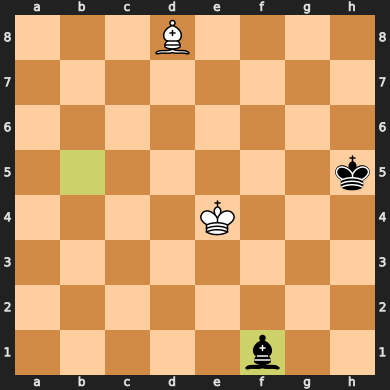

In [59]:
board

In [62]:
def evaluar(b):
        mapeo={
            'r':5.63,
            'n':3.05,
            'b':3.33,
            'q':9.5,
            'p':1,
        }
        b=str(b).replace('\n','').replace(' ','').replace('.','').replace('k','').replace('K','')
        white=1
        black=1
        for i in b:
            if i.islower():
                black+=mapeo[i]
            else:
                white+=mapeo[i.lower()]
        return [round(white/(white+black),5),round(black/(white+black),5)]

In [63]:
evaluar(board)

[0.5, 0.5]